<a href="https://colab.research.google.com/github/Balrog16/Test/blob/master/MIMII_Fan_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Background**

Fan audio data from MIMII database is played after combining a few files randomly to form two audio records - normal and abnormal, each lasting for 520 sec. This data is played on JBL Go speaker with SITRANS-MS placed in the middle of the speaker. This arrangement is to vibrate the sensor and obtain the stream via BLE using MATLAB scripts. There are two sets of JSON files each for Normal audio and abnormal audio data.


In [158]:
# all imports
import json
import numpy as np
import tensorflow as tf
from numpy import savetxt
import matplotlib.pyplot as plt

In [159]:
# code to shuffle 
# due credits to Josh Bleecher Snyder
# https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
def shuffle_in_unison_scary(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

In [160]:
class SMSData:
    def __init__(self, fileName, label):
        self.fileName = fileName
        f = open(self.fileName)
        data = json.load(f)
        self.accelX = np.array(data['values']['5FF8'])
        self.accelY = np.array(data['values']['5FF9'])
        self.accelZ = np.array(data['values']['5FFA'])
        # Collapse the last two columns to one by 2-norm of the components
        self.accelX = np.sqrt(np.square(self.accelX[:,:,0]) + np.square(self.accelX[:, :, 1]))
        self.accelY = np.sqrt(np.square(self.accelY[:,:,0]) + np.square(self.accelY[:, :, 1]))
        self.accelZ = np.sqrt(np.square(self.accelZ[:,:,0]) + np.square(self.accelZ[:, :, 1]))
        # Close the file
        f.close()
        self.minCols = (min(self.accelX.shape[1], self.accelY.shape[1], self.accelZ.shape[1]))
        self.accelX  = np.transpose(self.accelX[:, 0: self.minCols])
        self.accelY  = np.transpose(self.accelY[:, 0: self.minCols])
        self.accelZ  = np.transpose(self.accelZ[:, 0: self.minCols])
        self.yData   = np.ones([self.accelY.shape[0], 1])*label
        self.featVecA = self.accelX + self.accelY + self.accelZ 
        self.featVecB  = np.dstack((self.accelX, self.accelY, self.accelZ))


In [161]:
# create empty objects
SMSDataObjNormal_1   = []
SMSDataObjNormal_2   = []
SMSDataObjabNormal_1 = []
SMSDataObjabNormal_2 = []

# define a class object to hold the data
SMSDataObjNormal_1 = SMSData("/content/sample_data/normal_1_6dB_Fan.json", 0)
SMSDataObjNormal_2 = SMSData("/content/sample_data/normal_2_6dB_Fan.json", 0)
SMSDataObjabNormal_1 = SMSData("/content/sample_data/abnormal_1_6dB_Fan.json", 1)
SMSDataObjabNormal_2 = SMSData("/content/sample_data/abnormal_2_6dB_Fan.json", 1)
SMSDataObjabNormal_4 = SMSData("/content/sample_data/abnormal_4HP_6dB_Fan.json", 1)
SMSDataObjNormal_5 = SMSData("/content/sample_data/normal_5_6dB_Fan.json", 0)


In [163]:
# for debug purpose
print('No of columns used', SMSDataObjabNormal_1.minCols)
print('Size of each axis', np.shape(SMSDataObjabNormal_1.accelX))
print('Feature vector B looks like', np.shape(SMSDataObjabNormal_1.featVecB))
minCols = min(SMSDataObjNormal_1.minCols, SMSDataObjNormal_2.minCols, SMSDataObjabNormal_1.minCols, SMSDataObjabNormal_1.minCols, SMSDataObjabNormal_4.minCols)
print('Minimum cols across the data is', minCols)

No of columns used 513
Size of each axis (513, 256)
Feature vector B looks like (513, 256, 3)
Minimum cols across the data is 512


In [167]:
# get data in x (input) and y (output)
x = np.concatenate((SMSDataObjNormal_1.featVecB, SMSDataObjabNormal_1.featVecB, 
                    SMSDataObjNormal_2.featVecB, SMSDataObjabNormal_2.featVecB,
                    SMSDataObjabNormal_4.featVecB, SMSDataObjNormal_5.featVecB))

y = np.concatenate((SMSDataObjNormal_1.yData, SMSDataObjabNormal_1.yData, 
                    SMSDataObjNormal_2.yData, SMSDataObjabNormal_2.yData,
                    SMSDataObjabNormal_4.yData, SMSDataObjNormal_5.yData))

# now shuffle the data, it doesn't matter anymore if these appear in order 
shuffle_in_unison_scary(x, y)

print(np.shape(x), np.shape(y))

(3078, 256, 3) (3078, 1)


In [171]:
trainIdx = 2051
validIdx = 2051
testIdx = 2651
endIdx = 3075
# generate a dataset for training and testing
# the DC component is dropped to eliminate huge value in the axis pointing downwards
x[:, 0, 1] =0
x_train = x[1:trainIdx, :, :]
y_train = y[1:trainIdx, :]

x_valid = x[validIdx:testIdx, :, :]
y_valid = y[validIdx:testIdx, :]


x_test = x[testIdx:endIdx, :, :]
y_test = y[testIdx:endIdx, :]

# check vector shape
print(x_train.shape)
print(y_train.shape)

print(x_valid.shape)
print(y_valid.shape)

print(x_test.shape)
print(y_test.shape)

(2050, 256, 3)
(2050, 1)
(600, 256, 3)
(600, 1)
(424, 256, 3)
(424, 1)


Max of x, max of y, max of z 28.570807052391782 84.91832588029807 31.96464110935707


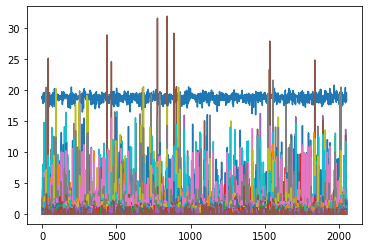

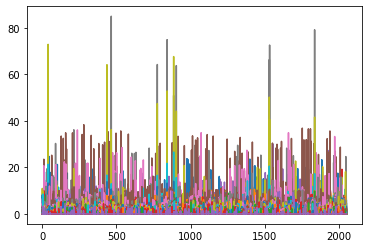

In [173]:
# plot the data
plt.plot(x_train[:, :, 2])
plt.figure(1)
print('Max of x, max of y, max of z', np.max(x_train[:,:,0]), np.max(x_train[:, :,1]), np.max(x_train[:,:,2]))
plt.figure(2)
plt.plot(x_train[:, 1:256 , 1])


In [174]:
# check vector shape
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)


(2050, 256, 3)
(2050, 1)
(424, 256, 3)
(424, 1)


In [175]:
# time to try NN

# model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(256, 3)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2)
])

# loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# settings
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
#model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [176]:
# train the dog
#trgHist = model.fit(x_train, y_train, epochs=25, batch_size=16, validation_data=(x_valid, y_valid))
trgHist = model.fit(x_train, y_train, epochs=25, validation_data=(x_valid, y_valid))

Epoch 1/25
65/65 [==============================] - 0s 3ms/step - loss: 0.3478 - accuracy: 0.8400 - val_loss: 0.1574 - val_accuracy: 0.9467
Epoch 2/25
65/65 [==============================] - 0s 2ms/step - loss: 0.1326 - accuracy: 0.9517 - val_loss: 0.1097 - val_accuracy: 0.9600
Epoch 3/25
65/65 [==============================] - 0s 2ms/step - loss: 0.0794 - accuracy: 0.9746 - val_loss: 0.0967 - val_accuracy: 0.9700
Epoch 4/25
65/65 [==============================] - 0s 2ms/step - loss: 0.0531 - accuracy: 0.9863 - val_loss: 0.0776 - val_accuracy: 0.9683
Epoch 5/25
65/65 [==============================] - 0s 2ms/step - loss: 0.0399 - accuracy: 0.9898 - val_loss: 0.0795 - val_accuracy: 0.9633
Epoch 6/25
65/65 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 0.9917 - val_loss: 0.0724 - val_accuracy: 0.9683
Epoch 7/25
65/65 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9941 - val_loss: 0.0762 - val_accuracy: 0.9633
Epoch 8/25
65/65 [==

In [ ]:
# plot


In [177]:
# ask him to perform tricks
model.evaluate(x_test[1:400],  y_test[1:400], verbose=2)

13/13 - 0s - loss: 0.0775 - accuracy: 0.9749


[0.07750463485717773, 0.9749373197555542]

In [153]:
# what's the probability?
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

probability_model(x_test[1:3])

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1.0000000e+00, 9.5147978e-10],
       [1.0178229e-07, 9.9999988e-01]], dtype=float32)>

In [116]:
predictNow = model(x_test[120:121]).numpy()
predictNow

array([[-2.6798193, -4.1256447]], dtype=float32)

In [188]:
SMSDataObjNormal_3 = SMSData("/content/sample_data/normal_3HP_6dB_Fan.json", 0)
print('Feature vector B looks like', np.shape(SMSDataObjNormal_3.featVecB))
x_test_a = SMSDataObjNormal_3.featVecB[1:trainIdx, :, :]
y_test_a = SMSDataObjNormal_3.yData[1:trainIdx, :]
x_test_ab[:, 0, 1] =0
print(np.shape(x_test_a), np.shape(y_test_a))                          

Feature vector B looks like (512, 256, 3)
(511, 256, 3) (511, 1)


In [189]:
model.evaluate(x_test_a,  y_test_a, verbose=2)

16/16 - 0s - loss: 0.0094 - accuracy: 0.9941


[0.009401150979101658, 0.9941291809082031]

In [184]:
SMSDataObjabNormal_3 = SMSData("/content/sample_data/abnormal_3HP_6dB_Fan.json", 1)
print('Feature vector B looks like', np.shape(SMSDataObjabNormal_3.featVecB))
x_test_ab = SMSDataObjabNormal_3.featVecB[1:trainIdx, :, :]
y_test_ab = SMSDataObjabNormal_3.yData[1:trainIdx, :]
x_test_ab[:, 0, 1] =0
print(np.shape(x_test_ab), np.shape(y_test_ab))   

Feature vector B looks like (513, 256, 3)
(512, 256, 3) (512, 1)


In [185]:
model.evaluate(x_test_ab,  y_test_ab, verbose=2)

16/16 - 0s - loss: 2.3763 - accuracy: 0.7402


[2.3762824535369873, 0.740234375]

In [186]:
SMSDataObjNormal_4 = SMSData("/content/sample_data/normal_4HP_6dB_Fan.json", 0)
print('Feature vector B looks like', np.shape(SMSDataObjNormal_4.featVecB))
x_test_ab = SMSDataObjNormal_4.featVecB[1:trainIdx, :, :]
y_test_ab = SMSDataObjNormal_4.yData[1:trainIdx, :]
x_test_ab[:, 0, 1] =0
print(np.shape(x_test_ab), np.shape(y_test_ab))  

Feature vector B looks like (513, 256, 3)
(512, 256, 3) (512, 1)


In [187]:
model.evaluate(x_test_ab,  y_test_ab, verbose=2)

16/16 - 0s - loss: 0.1716 - accuracy: 0.9609


[0.17163285613059998, 0.9609375]